In [83]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim import corpora, models, similarities, matutils

import nltk
from nltk.corpus import stopwords

from pprint import pprint

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer


In [84]:
#Samaras Laptop
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\DIE_DATEN\datensatz.csv')
#song_data = song_data[(song_data['Language'] == 'en')]
#song_data.to_csv("outData.csv", index=False)
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\outData.csv')


#Anjas Laptop
# song_data = pd.read_csv('../Daten/train.csv')
# song_data = song_data[(song_data['Language'] == 'en')]
# song_data.to_csv("../Daten/outData.csv", index=False)
song_data = pd.read_csv('../Daten/outData.csv')

## Get a balanced sample of 5 songs per genre

In [123]:
num_genres = song_data.Genre.nunique()
num_topics = num_genres

In [124]:
song_data = song_data[["Genre", "Lyrics"]]
song_data = song_data.groupby('Genre').sample(50).reset_index(drop=True)
song_data.head(10)

,Genre,Lyrics
0,Country,She's the sky that holds the clouds She's the ...
1,Country,Couldn't tell my teacher my last name when I w...
2,Country,Oh somewhere the music's playing soft and low ...
3,Country,"Little by little, now babe I've come a long, l..."
4,Country,You'll never be the sun turning in the sky And...
5,Country,I'm not the first to make you cry I always pro...
6,Country,Everyone has heard me say I don't miss her muc...
7,Country,Today my life is so much brighter and I know h...
8,Country,All afternoon I sit alone and contemplate the ...
9,Country,"Talk about life, talk about death Talk about c..."


## Remove punctuation/lower casing

In [125]:
song_data_processed = song_data.copy()
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].map(lambda x: re.sub('[,\.!?]', '', x))
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].map(lambda x: x.lower())

## Remove stopwords and Tokenize

In [126]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anjan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [127]:
stop_words = stopwords.words('english')
new_stop_words = ['ooh','oh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa', 'intro', 'chorus', 'bridge', 'refrain']
stop_words.extend(new_stop_words)

max_df: je niedriger dieser Wert, desto mehr Mainstream wörter, die in allen songs vorkommen, werden nicht beachtet

In [128]:
#Turn Lyrics into vectorized form (based on counts)
count_vec = CountVectorizer(stop_words=stop_words, max_df=0.2, min_df=0.01, ngram_range=(1,1))
words_df = count_vec.fit_transform(song_data_processed.Lyrics)

In [129]:
words_df = words_df.transpose()
corpus = matutils.Sparse2Corpus(words_df)
id2word = dict((v, k) for k, v in count_vec.vocabulary_.items())
lda = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=100, random_state=11)

In [130]:
lda.print_topics(num_words=10)

[(0,
  '0.049*"give" + 0.023*"good" + 0.013*"much" + 0.013*"dream" + 0.012*"world" + 0.012*"need" + 0.012*"long" + 0.012*"light" + 0.010*"little" + 0.009*"mi"'),
 (1,
  '0.024*"move" + 0.023*"em" + 0.020*"high" + 0.019*"jump" + 0.017*"ya" + 0.016*"always" + 0.014*"side" + 0.013*"keep" + 0.013*"hear" + 0.012*"baby"'),
 (2,
  '0.025*"baby" + 0.015*"everything" + 0.013*"real" + 0.013*"forever" + 0.013*"even" + 0.011*"people" + 0.011*"girl" + 0.011*"world" + 0.010*"talk" + 0.010*"said"'),
 (3,
  '0.027*"fire" + 0.025*"pain" + 0.023*"water" + 0.019*"wrong" + 0.018*"man" + 0.016*"kind" + 0.016*"soul" + 0.014*"right" + 0.014*"tears" + 0.012*"wash"'),
 (4,
  '0.032*"niggas" + 0.023*"ya" + 0.020*"nigga" + 0.020*"fuck" + 0.017*"new" + 0.015*"bitch" + 0.015*"wanna" + 0.015*"shit" + 0.014*"baby" + 0.012*"money"'),
 (5,
  '0.028*"da" + 0.016*"gone" + 0.016*"die" + 0.012*"stop" + 0.012*"need" + 0.011*"thought" + 0.010*"fear" + 0.010*"streets" + 0.010*"think" + 0.010*"eyes"'),
 (6,
  '0.018*"cry" + 0

In [131]:
docTopicProbMat = lda[corpus]
csr = matutils.corpus2csc(docTopicProbMat)
doc_top = csr.T.toarray()
doc_top_df = pd.DataFrame(doc_top, columns = [i for i in range(0, num_topics)])
results = pd.merge(song_data_processed, doc_top_df, left_index=True, right_index=True)
results['Dominant_Topic'] = results[[i for i in range(0, num_topics)]].idxmax(axis=1)
results

,Genre,Lyrics,0,1,2,3,4,5,6,7,8,9,Dominant_Topic
0,Country,she's the sky that holds the clouds she's the ...,0.666980,0.000000,0.000000,0.000000,0.000000,0.323603,0.000000,0.000000,0.000000,0.000000,0
1,Country,couldn't tell my teacher my last name when i w...,0.286493,0.000000,0.000000,0.140994,0.000000,0.000000,0.192558,0.000000,0.317210,0.056492,8
2,Country,oh somewhere the music's playing soft and low ...,0.304978,0.000000,0.000000,0.000000,0.134465,0.156545,0.000000,0.000000,0.000000,0.387786,9
3,Country,little by little now babe i've come a long lon...,0.838955,0.000000,0.000000,0.145653,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,Country,you'll never be the sun turning in the sky and...,0.441987,0.000000,0.271213,0.152391,0.000000,0.000000,0.000000,0.000000,0.000000,0.122160,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Rock,[verse 1]\ni'm from brooklyn vandals bedrocks\...,0.000000,0.000000,0.000000,0.073836,0.223966,0.000000,0.000000,0.067628,0.000000,0.629012,9
496,Rock,daytime turns me off and i don't mean maybe\nn...,0.000000,0.135489,0.155177,0.000000,0.000000,0.000000,0.000000,0.383783,0.000000,0.314638,7
497,Rock,take me out tonight \nwhere theres music and t...,0.000000,0.786876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.202863,0.000000,1
498,Rock,she's just a girl and she's on fire\nhotter th...,0.000000,0.000000,0.653548,0.336572,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2


### Explore Results

#### Crosstab

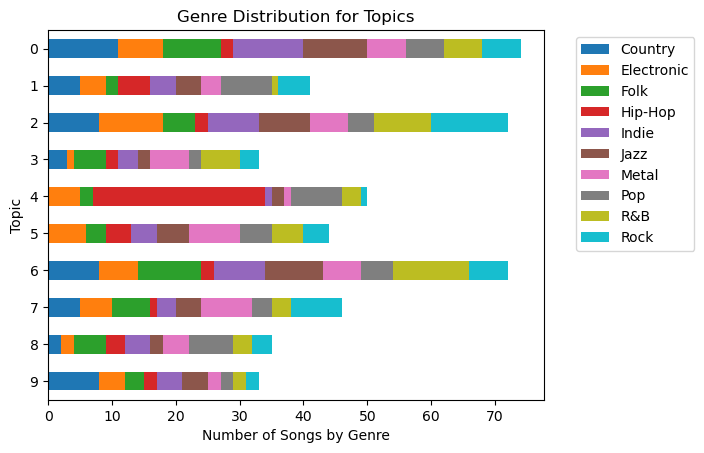

In [132]:
# Create a crosstab
crosstab = pd.crosstab(results['Dominant_Topic'], results['Genre']).sort_values(by="Dominant_Topic", ascending=False)

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of Songs by Genre')
plt.ylabel('Topic')
plt.title('Genre Distribution for Topics')
plt.show()

#### Visualization (PCA) (visualizing LDA Results)

In [133]:
results

,Genre,Lyrics,0,1,2,3,4,5,6,7,8,9,Dominant_Topic
0,Country,she's the sky that holds the clouds she's the ...,0.666980,0.000000,0.000000,0.000000,0.000000,0.323603,0.000000,0.000000,0.000000,0.000000,0
1,Country,couldn't tell my teacher my last name when i w...,0.286493,0.000000,0.000000,0.140994,0.000000,0.000000,0.192558,0.000000,0.317210,0.056492,8
2,Country,oh somewhere the music's playing soft and low ...,0.304978,0.000000,0.000000,0.000000,0.134465,0.156545,0.000000,0.000000,0.000000,0.387786,9
3,Country,little by little now babe i've come a long lon...,0.838955,0.000000,0.000000,0.145653,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,Country,you'll never be the sun turning in the sky and...,0.441987,0.000000,0.271213,0.152391,0.000000,0.000000,0.000000,0.000000,0.000000,0.122160,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Rock,[verse 1]\ni'm from brooklyn vandals bedrocks\...,0.000000,0.000000,0.000000,0.073836,0.223966,0.000000,0.000000,0.067628,0.000000,0.629012,9
496,Rock,daytime turns me off and i don't mean maybe\nn...,0.000000,0.135489,0.155177,0.000000,0.000000,0.000000,0.000000,0.383783,0.000000,0.314638,7
497,Rock,take me out tonight \nwhere theres music and t...,0.000000,0.786876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.202863,0.000000,1
498,Rock,she's just a girl and she's on fire\nhotter th...,0.000000,0.000000,0.653548,0.336572,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2


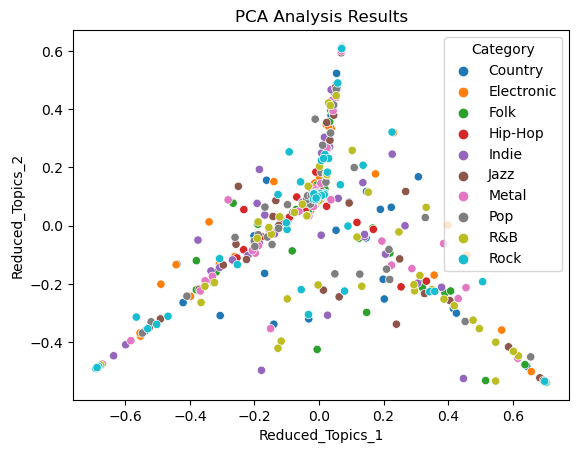

In [134]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(results[[i for i in range(0, num_topics)]])
results[['Reduced_Topics_1', 'Reduced_Topics_2']] = reduced
#Scatter Plot
sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Genre', data=results)
plt.title('PCA Analysis Results')
plt.legend(title='Category')
plt.show()

### Using Clustering

In [135]:
kmeans = KMeans(n_clusters=num_genres, random_state=0).fit(results[[i for i in range(0, num_topics)]])
results["Cluster"] = kmeans.labels_
results

c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


,Genre,Lyrics,0,1,2,3,4,5,6,7,8,9,Dominant_Topic,Reduced_Topics_1,Reduced_Topics_2,Cluster
0,Country,she's the sky that holds the clouds she's the ...,0.666980,0.000000,0.000000,0.000000,0.000000,0.323603,0.000000,0.000000,0.000000,0.000000,0,0.055990,0.471952,4
1,Country,couldn't tell my teacher my last name when i w...,0.286493,0.000000,0.000000,0.140994,0.000000,0.000000,0.192558,0.000000,0.317210,0.056492,8,0.146903,0.117151,4
2,Country,oh somewhere the music's playing soft and low ...,0.304978,0.000000,0.000000,0.000000,0.134465,0.156545,0.000000,0.000000,0.000000,0.387786,9,0.020531,0.266059,9
3,Country,little by little now babe i've come a long lon...,0.838955,0.000000,0.000000,0.145653,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.054263,0.523239,4
4,Country,you'll never be the sun turning in the sky and...,0.441987,0.000000,0.271213,0.152391,0.000000,0.000000,0.000000,0.000000,0.000000,0.122160,0,-0.162589,0.155796,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Rock,[verse 1]\ni'm from brooklyn vandals bedrocks\...,0.000000,0.000000,0.000000,0.073836,0.223966,0.000000,0.000000,0.067628,0.000000,0.629012,9,-0.010589,0.089065,9
496,Rock,daytime turns me off and i don't mean maybe\nn...,0.000000,0.135489,0.155177,0.000000,0.000000,0.000000,0.000000,0.383783,0.000000,0.314638,7,-0.101128,0.009239,2
497,Rock,take me out tonight \nwhere theres music and t...,0.000000,0.786876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.202863,0.000000,1,-0.009065,0.094498,0
498,Rock,she's just a girl and she's on fire\nhotter th...,0.000000,0.000000,0.653548,0.336572,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,-0.467873,-0.312142,3


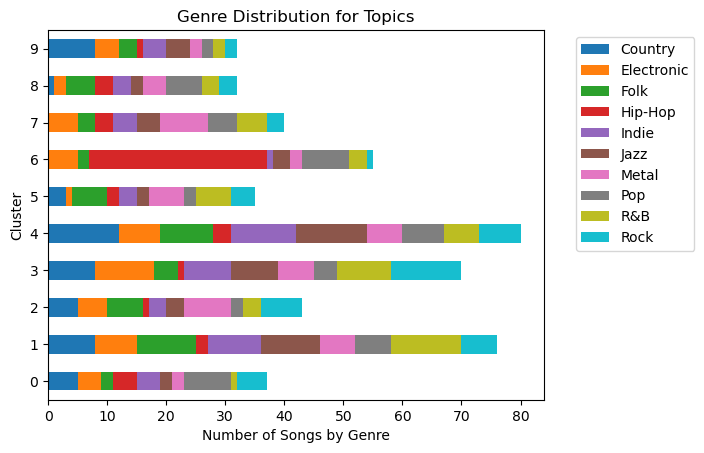

In [136]:
# Create a crosstab
crosstab = pd.crosstab(results['Cluster'], results['Genre'])

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of Songs by Genre')
plt.ylabel('Cluster')
plt.title('Genre Distribution for Topics')
plt.show()

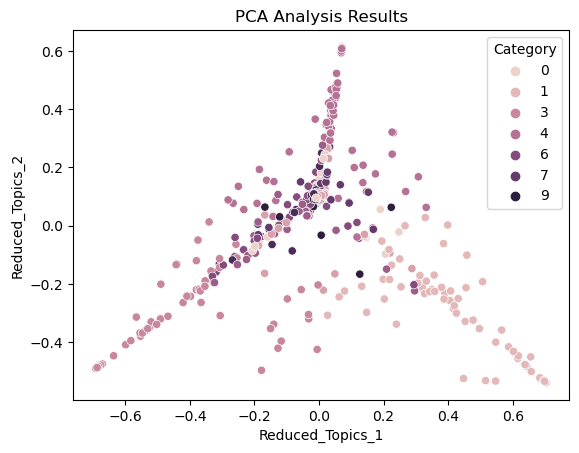

In [137]:
#Scatter Plot
sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Cluster', data=results)
plt.title('PCA Analysis Results')
plt.legend(title='Category')
plt.show()

### Trying to predict the genre based on the topic vector

In [138]:
X = results[[i for i in range(0, num_topics)]]
label_encoder = LabelEncoder()
results["GenreID"] = label_encoder.fit_transform(results["Genre"])
y = results["GenreID"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [139]:
#K-nearest neighbors
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

0.11333333333333333

In [140]:
#svm classifier
svc = SVC(kernel="rbf")
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.13333333333333333

In [141]:
#Random forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.16

### Was hier gemacht wurde:
- Nehmen eines song subsets mit jeweils n songs aus jedem der m genres
- Bereinigen der Lyrics mit verschiedenen Preprocessing methoden (Best Practice)
- Using LDA to get most important topic based on all the songs
- applying the LDA topics to each song individually
- Investigating whether there is a correlation between the topics and the song genres, using crosstabs and, PCA-Scatterplots and Clustering
- Investigating whether it is possible to predict a genre based on its most prominent topics 

### Ergebnis
- Teils Zusammenhang zwischen prominenten Topics und Song Genres
- Vor Allem HipHop Topics fallen auffallend oft in die gleiche Kategorie
- Ergebnisse eindeutiger als bei der Vorherigen Lösung
- Vorhersage des Genres aus Topics nach wie vor nur schlecht möglich

### Interpretation
- Das Model funktioniert bereits besser als das vorherige. Die Vermutung liegt nahe, dass es zwischen manchen Genres mehr Unterschiede als zwischen anderen gibt. Ein gutes beispiel dafür ist HipHop, das sich relativ klar unterscheiden lässt.